### Підключаємо пакети

In [ ]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering, KMeans, MiniBatchKMeans
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

import warnings; warnings.simplefilter('ignore')

### Зчитуємо дані

In [75]:
df = pd.read_csv('Country-data.csv')
df.set_index('country', inplace = True)

df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [76]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


### Відкидаємо значення

In [77]:
print(df.isnull().sum())
df = df.dropna()

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


### Однофакторний аналіз

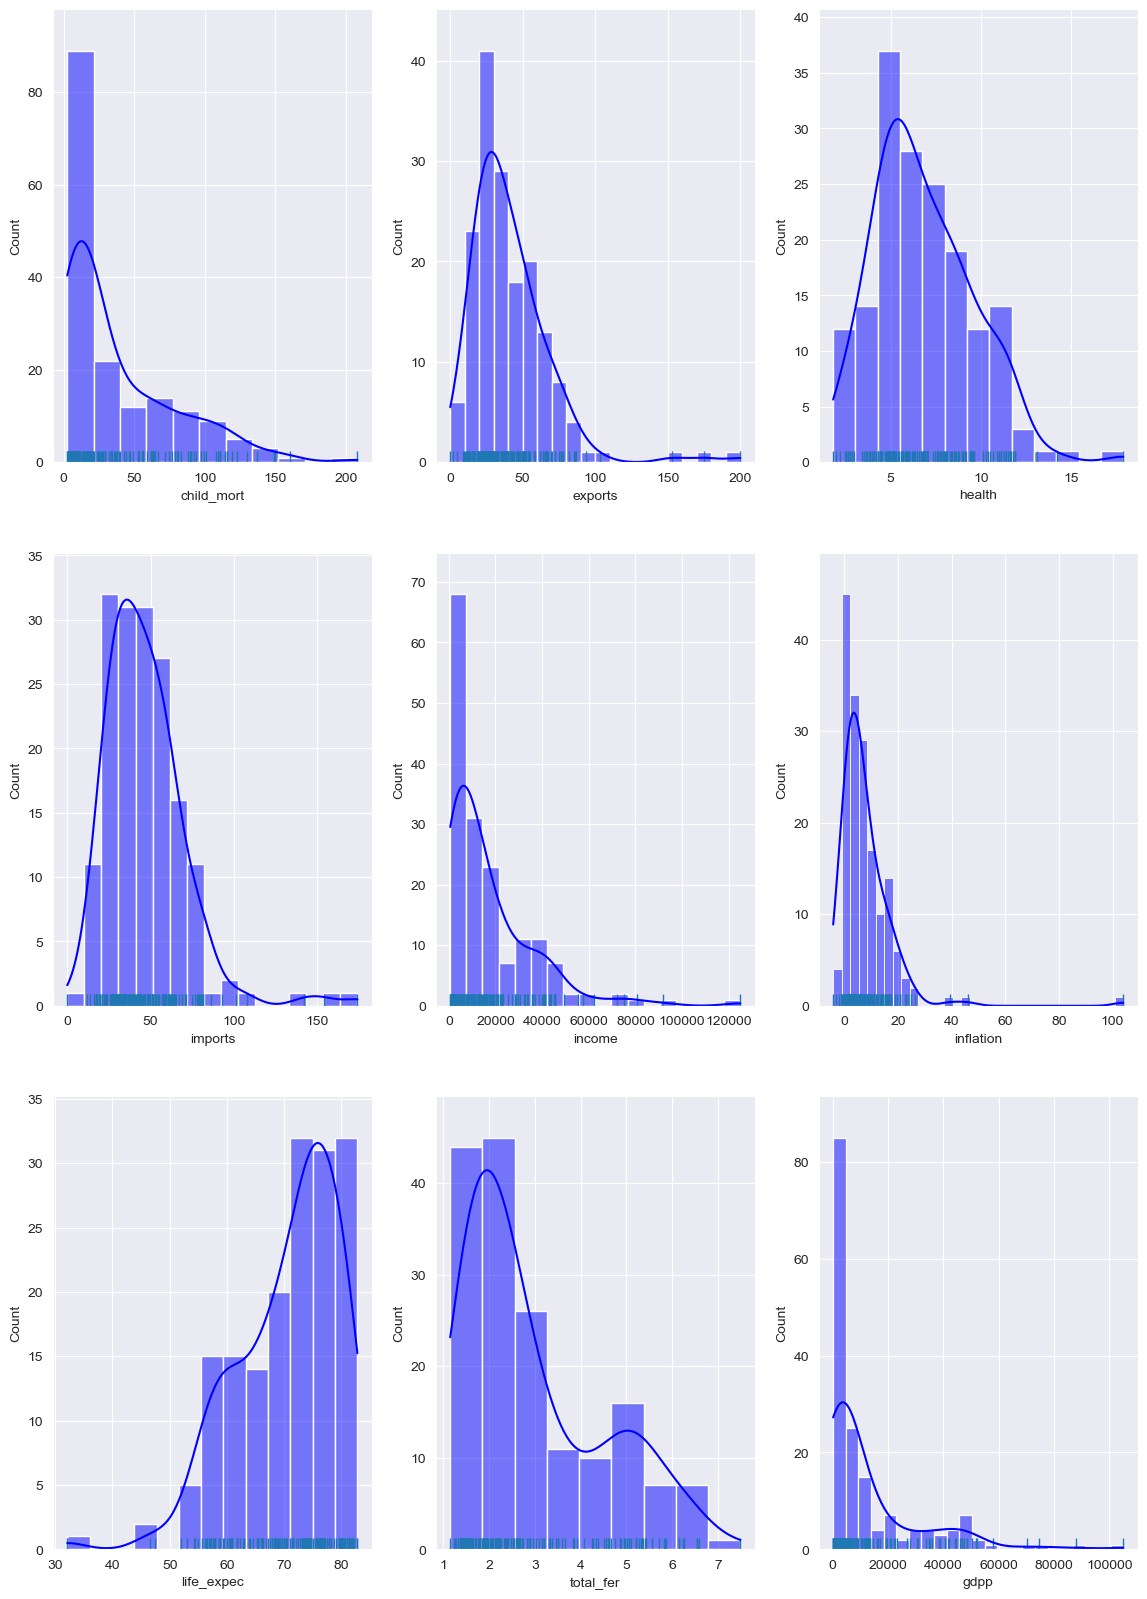

In [78]:
plt.figure(figsize = (14, 20))
for i, column in enumerate(df.columns):
    column_data = df[column]
    plt.subplot(3, 3, i + 1)
    sb.histplot(column_data, kde = True, color = "blue")
    sb.rugplot(column_data)
plt.show()

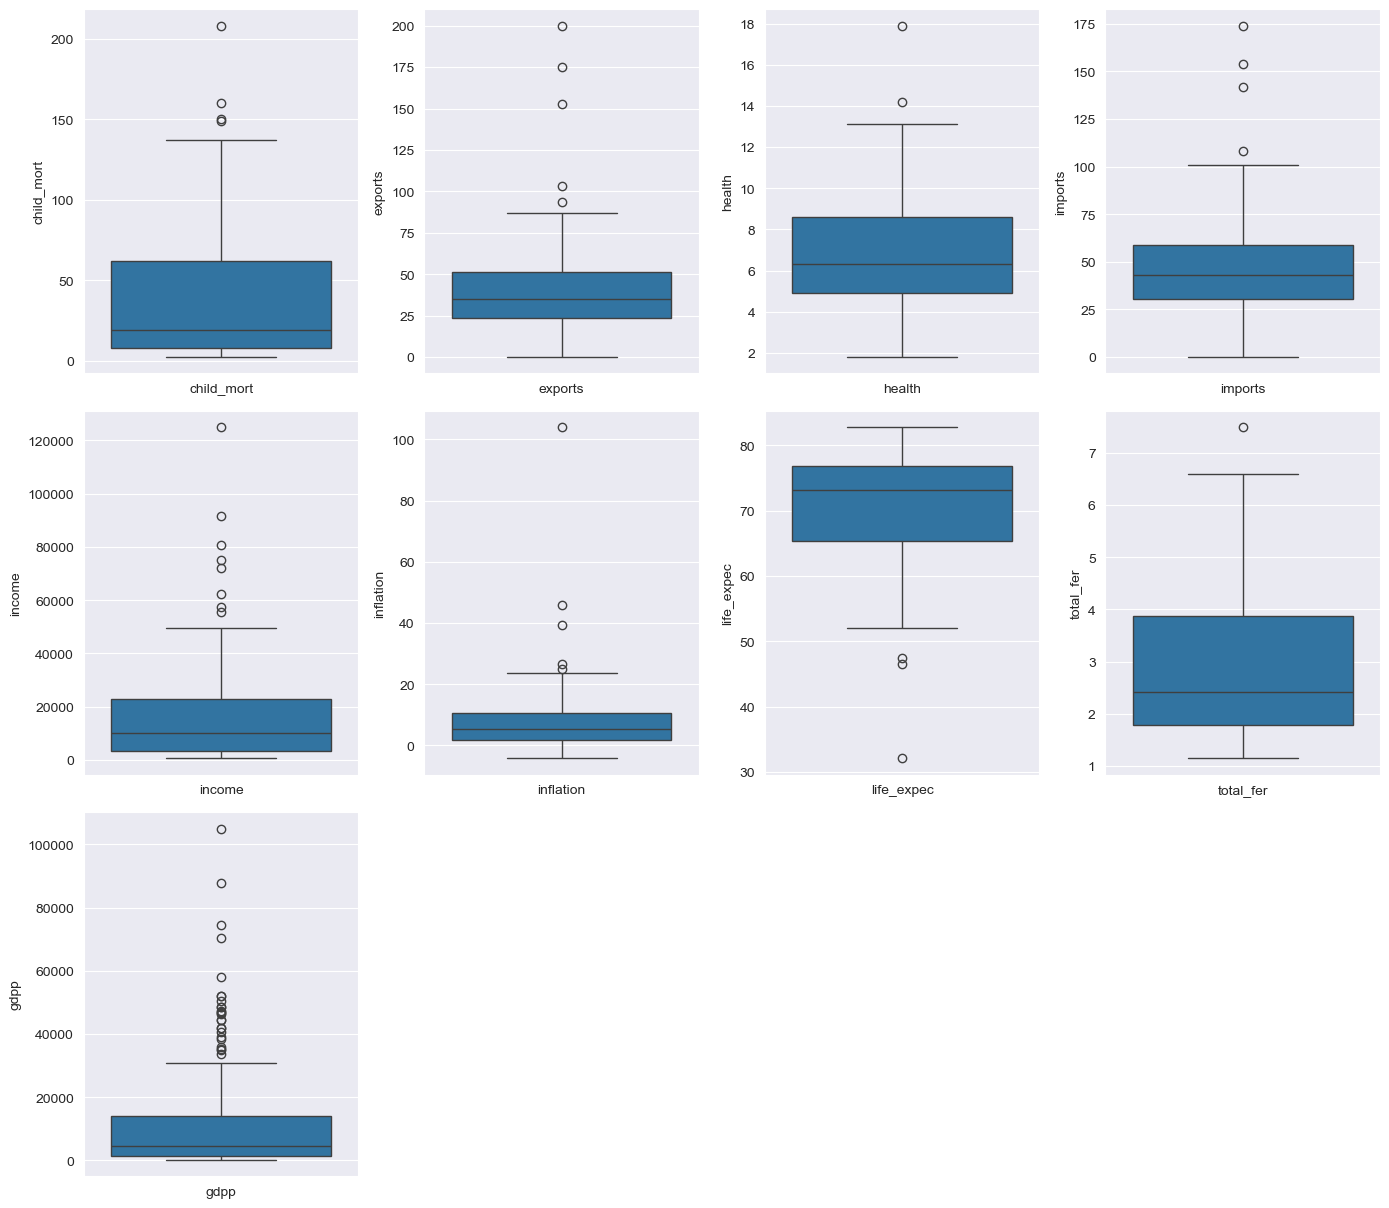

In [79]:
plt.figure(figsize = (14, 20))
for i, column in enumerate(df.columns):
    plt.subplot(5, 4, i + 1)
    sb.boxplot(data = df[column])
    plt.xticks([0], [column])
plt.tight_layout()
plt.show()

### Кластеризація

In [80]:
def kmeansClustering(df, feature_columns):
    X = df[feature_columns].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters = k, random_state = 42)
        kmeans.fit(X_scaled)
        sse.append(kmeans.inertia_)

    kl = KneeLocator(range(1, 11), sse, curve='convex', direction='decreasing')
    optimal_k = kl.elbow
    kl.elbow

    plt.plot(range(1, 11), sse, marker = 'o')
    plt.title('Optimal k')
    plt.xlabel('кількість кластерів (k)')
    plt.ylabel('Сума квадратів відстаней')

    plt.plot(optimal_k, sse[optimal_k - 1], marker = 'o', markersize = 8, color = 'red', label = 'Optimal k')
    plt.legend()
    plt.show()

    kmeans_optimal = KMeans(n_clusters = optimal_k, random_state = 42)
    y_kmeans_optimal = kmeans_optimal.fit_predict(X_scaled)

    scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c = y_kmeans_optimal, cmap = 'viridis', s = 50)

    legend_labels = list(range(optimal_k))
    plt.legend(handles = scatter.legend_elements()[0], labels = legend_labels, title = "Clusters")

    plt.title(f'K-Means Clustering with Optimal k={optimal_k}')
    plt.xlabel(f'{feature_columns[0]}')
    plt.ylabel(f'{feature_columns[1]}')
    plt.show()

    country_cluster_df = pd.DataFrame({'Country': df.index, 'Cluster': y_kmeans_optimal})
    merged_df = pd.merge(country_cluster_df, df, left_on='Country', right_index=True)
    return merged_df

In [81]:
def showCountries(df, cluster_number, column, second_column, ascending = True):
    cluster_df = df[df['Cluster'] == cluster_number]
    sorted_countries = cluster_df.sort_values(by = column, ascending = ascending)
    print(sorted_countries[['Country', column, second_column]].head(5))

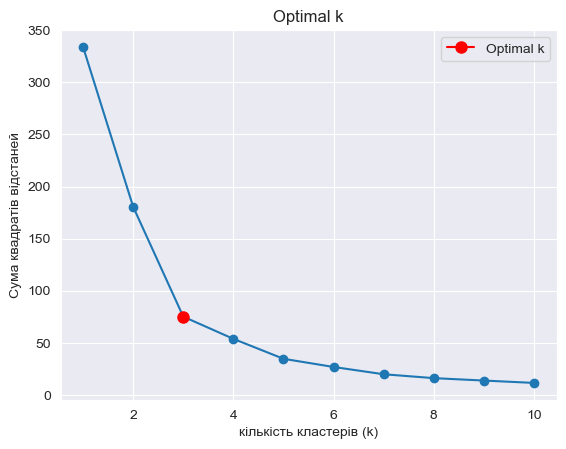

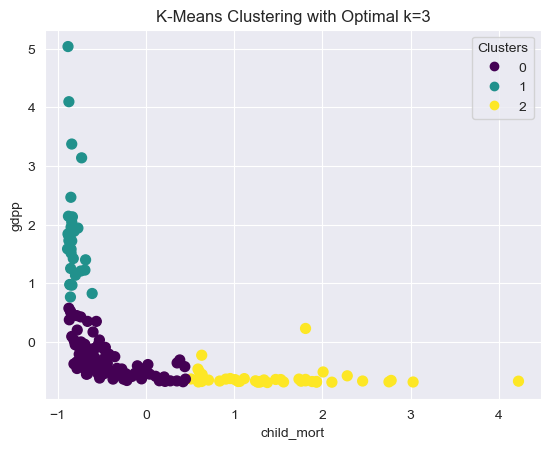

In [82]:
child_mort_gdpp = kmeansClustering(df, ['child_mort', 'gdpp']) 

In [83]:
showCountries(child_mort_gdpp, cluster_number = 2, column='child_mort',second_column = 'gdpp', ascending = False)

                      Country  child_mort  gdpp
66                      Haiti       208.0   662
132              Sierra Leone       160.0   399
32                       Chad       150.0   897
31   Central African Republic       149.0   446
97                       Mali       137.0   708


**На мою думку, країна Гаїті потребує найбільшої підртимки, так як має доволі низький показник ВВП та великий показник смертей серед дітей**

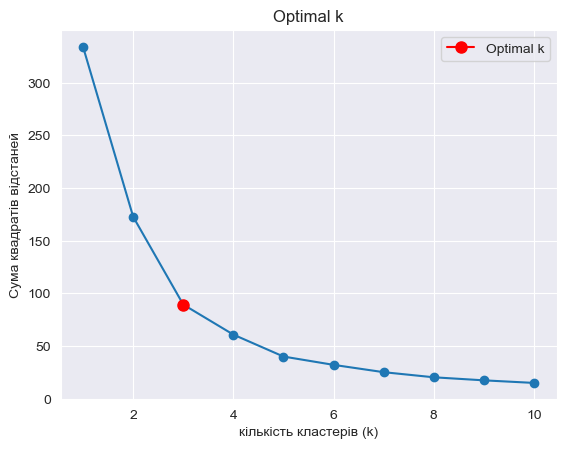

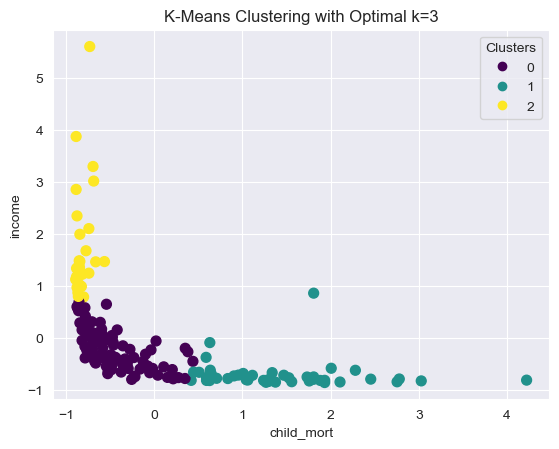

In [84]:
child_mort_income_df = kmeansClustering(df, ['child_mort', 'income'])

In [85]:
showCountries(child_mort_gdpp, cluster_number = 2, column='child_mort',second_column = 'income', ascending = False)

                      Country  child_mort  income
66                      Haiti       208.0    1500
132              Sierra Leone       160.0    1220
32                       Chad       150.0    1930
31   Central African Republic       149.0     888
97                       Mali       137.0    1870


**На мою думку, найбільшої допомоги потребує країна Гаїті, яка має великий показник смертей серед дітей та малий дохід**

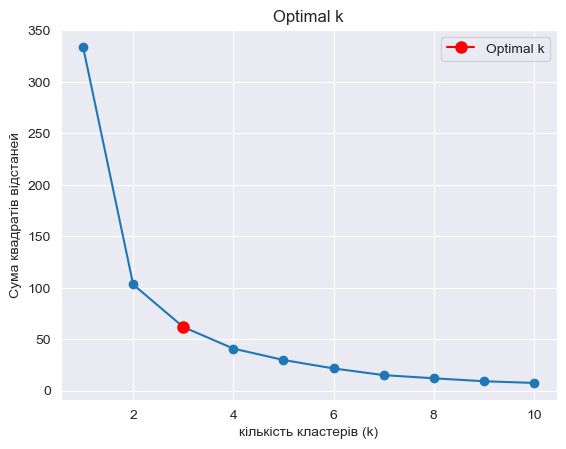

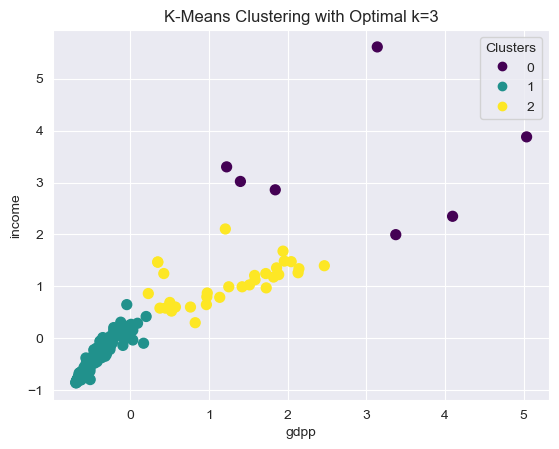

In [88]:
child_mort_income_df = kmeansClustering(df, ['gdpp', 'income'])

In [90]:
showCountries(child_mort_gdpp, cluster_number = 2, column='gdpp',second_column = 'income', ascending = True)

              Country  gdpp  income
26            Burundi   231     764
88            Liberia   327     700
37   Congo, Dem. Rep.   334     609
112             Niger   348     814
132      Sierra Leone   399    1220


**На мою думку, країна Бурудні, яка має найменший показник ВВП потребує найбільшої допомоги.**
**У підсумку, на мою думку, найбільшої допомоги потребує країна Гаїті, яка має шалений показник смертності серед дітей і цей показник більший за попередню країну на 48, та доволі малим, хоч і не найменшим, показником ВВП.** 